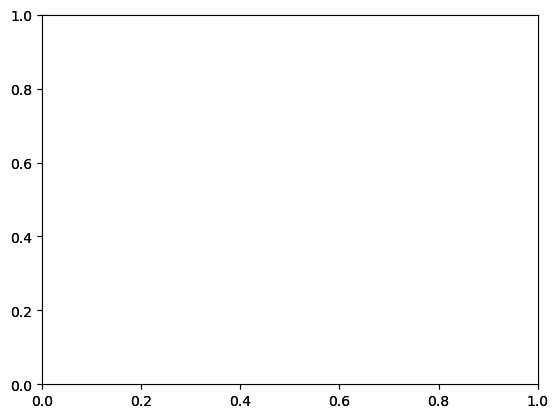

In [1]:
from input_output import *
import altair as alt
# results_name, results, target_name, target = choose_results_and_target()

In [2]:
results = choose_results("AlloSolidCube_X1_12Dec22")
target_name = "solidcube"
target = results.targets[target_name]

In [3]:
# # narrow type = set of parameters specifying bonding angles between patches
# nt = int(input(f"Input the narrow type of the data ({', '.join([f'{nt}' for nt in results.narrow_types()])}): "))
# # cutoff = the lower limit for counting clusters as partially assembled forms of the target
# # cutoff = 1 -> only count fully assembled clusters
# cutoff = float(input("Input the graph match cutoff: "))
# relative = input("Calculate relative yields?") == "True"
# overreach = input("Include overreaching graphs in yield calculations?") == "True"
# rs = input("Enter resample  frequency (in kilosteps, should be >= to the observable print interval):")

In [4]:
# narrow type = set of parameters specifying bonding angles between patches
nt =1
# cutoff = the lower limit for counting clusters as partially assembled forms of the target
# cutoff = 1 -> only count fully assembled clusters
cutoff = 1
relative =True
overreach =False
rs =1000
interval=250

In [5]:
df = results.get_stats(target_name, sample_every=interval,verbose=True, cutoff=cutoff)
df = df.reset_index()

Fetching yield data from file /scratch/jrevan21/analysis_space/AlloSolidCube_X1_12Dec22/DEFAULT_duplicate_0/nt0/T_0.01/cluster_yields_solidcube_C1_OFalse.pickle...
Fetching yield data from file /scratch/jrevan21/analysis_space/AlloSolidCube_X1_12Dec22/DEFAULT_duplicate_0/nt0/T_0.02/cluster_yields_solidcube_C1_OFalse.pickle...
Fetching yield data from file /scratch/jrevan21/analysis_space/AlloSolidCube_X1_12Dec22/DEFAULT_duplicate_0/nt0/T_0.05/cluster_yields_solidcube_C1_OFalse.pickle...
Fetching yield data from file /scratch/jrevan21/analysis_space/AlloSolidCube_X1_12Dec22/DEFAULT_duplicate_0/nt0/T_0.08/cluster_yields_solidcube_C1_OFalse.pickle...
Fetching yield data from file /scratch/jrevan21/analysis_space/AlloSolidCube_X1_12Dec22/DEFAULT_duplicate_0/nt0/T_0.1/cluster_yields_solidcube_C1_OFalse.pickle...
Fetching yield data from file /scratch/jrevan21/analysis_space/AlloSolidCube_X1_12Dec22/DEFAULT_duplicate_0/nt1/T_0.01/cluster_yields_solidcube_C1_OFalse.pickle...
Fetching yield da

/home/jrevan21/patchy-analysis/patchyresults.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgs = gb.mean()
/home/jrevan21/patchy-analysis/patchyresults.py:183: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgs["yield_stdev"] = gb.std()['yield'].fillna(0)


In [6]:
df

,nt,temp,time,yield,num_assemblies,yield_min,yield_max,yield_stdev
0,0,0.01,0.000000e+00,0.0,10.0,0.0,0.0,0.000000
1,0,0.01,1.000000e+09,0.0,10.0,0.0,0.0,0.000000
2,0,0.01,2.000000e+09,0.0,10.0,0.0,0.0,0.000000
3,0,0.01,2.500000e+09,1.0,10.0,0.0,2.0,1.414214
4,0,0.02,0.000000e+00,0.0,10.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
69,3,0.05,0.000000e+00,0.0,10.0,0.0,0.0,0.000000
70,3,0.05,2.500000e+09,0.0,10.0,0.0,0.0,0.000000
71,3,0.08,0.000000e+00,0.0,10.0,0.0,0.0,0.000000
72,3,0.08,2.500000e+09,0.0,10.0,0.0,0.0,0.000000


In [7]:
df = df[df['nt'] == nt]

In [8]:
# data = []ValueError: shape encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

# for run_result in results.flat_runs():
#     data += results.annanosecondsalyseClusterYield(run_result, target=target_name)
# df = pd.DataFrame(data)
# # df['time'] /= 10e6 # to make data more readable

rule_data = pd.DataFrame(
    [
        {
            'run_name': results.runs[int(i / len(results.rule))].name,

            'cube_name': results.rule[i % len(results.rule)].name,
            'level': lvl
        }
        for i, lvl in enumerate(itertools.chain.from_iterable([r.cube_type_levels for r in results.runs]))
    ]
)



In [9]:
# df.set_index(['time','shape','temp','potential','duplicate'], inplace=True)

max_time = df['time'].max()
max_yield = df['yield'].max()

In [10]:
yield_data = [df[df['temp'] == t] for t in df['temp'].unique()]

In [11]:
if (relative):
    for t, yld in zip(results.temperatures, yield_data):
        yld['yield'] = yld['yield'] / (yld['num_assemblies'] * target['rel_count'])
        yld['yield_min'] = yld['yield_min'] / (yld['num_assemblies'] * target['rel_count'])
        yld['yield_max'] = yld['yield_max'] / (yld['num_assemblies'] * target['rel_count'])
        yld['yield_stdev'] = yld['yield_stdev'] / (yld['num_assemblies'] * target['rel_count'])
    ymax = 1
    x_axis_format = '.0%'
else:
    if (df['num_assemblies'].unique().size > 1):
        print ("Assembly counts are not consistant, scaling may be wonky. You may want to do a relative yield analysis.")
    ymax = df['num_assemblies'].max() * target['rel_count']
    x_axis_format = '.00'

/tmp/ipykernel_5223/3677856084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yld['yield'] = yld['yield'] / (yld['num_assemblies'] * target['rel_count'])
/tmp/ipykernel_5223/3677856084.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yld['yield_min'] = yld['yield_min'] / (yld['num_assemblies'] * target['rel_count'])
/tmp/ipykernel_5223/3677856084.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [12]:
charts = []
chart_w = 800
chart_h = 250
for i, yld in enumerate(yield_data):
    charts.append(alt.Chart(yld, title="Assembly Yields at T=%f" % results.temperatures[i]))
    charts[i] = charts[i].mark_line().encode(
            x=alt.X('time:Q', title="Time (megasteps)", axis=alt.Axis(tickCount=5)),
            y=alt.Y(
                "yield:Q",
                title="Yield",
                scale=alt.Scale(
                    domain=(0, ymax)
                ),
                axis=alt.Axis(format=x_axis_format)
            ),
            color=alt.Color('shape', scale=alt.Scale(scheme="accent"), title="Configuration")
    )
    charts[i] = charts[i].properties(width=int(chart_w / len(results.temperatures)), height=chart_h)
    errbars = charts[i].mark_area(opacity=0.25).encode(
        x="time:Q",
        y="yield_min:Q",
        y2="yield_max:Q"
    )
    charts[i] = charts[i] + errbars
        
chart = alt.hconcat(
    alt.Chart(rule_data).mark_bar().encode(
        x=alt.X('run_name', title="Configuration"),
        y=alt.Y('level', title="Level"),
        color=alt.Color('cube_name', title="Type")
    ),
    *charts
)

# ) + alt.Chart(df).mark_errorband(extent='ci', opacity=0.2).encode(
#     x=alt.X('time:Q'),
#     y=alt.Y('yield', title='Yield'),
#     color = alt.Color('shape', scale=alt.Scale())
# )).properties(width=600, height=450).facet(column='potential', row='type').properties(title=sim_name)

chart.properties(title=f"{results.export_name} - {target_name} - NT{nt} - Cutoff:{cutoff} (Overreach{' ' if overreach else ' not '} allowed)")
# chart.save(sims_root() + os.sep + results.export_name + os.sep + results.export_name + ".html")

/home/jrevan21/.conda/envs/polycubes2/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


ValueError: shape encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

alt.HConcatChart(...)

In [13]:
df

,nt,temp,time,yield,num_assemblies,yield_min,yield_max,yield_stdev
22,1,0.01,0.000000e+00,0.0,10.0,0.0,0.0,0.0
23,1,0.01,1.000000e+09,0.0,10.0,0.0,0.0,0.0
24,1,0.01,2.000000e+09,0.0,10.0,0.0,0.0,0.0
25,1,0.01,2.500000e+09,0.0,10.0,0.0,0.0,0.0
26,1,0.01,3.000000e+09,0.0,10.0,0.0,0.0,0.0
27,1,0.02,0.000000e+00,0.0,10.0,0.0,0.0,0.0
28,1,0.02,1.000000e+09,0.0,10.0,0.0,0.0,0.0
29,1,0.02,2.000000e+09,0.0,10.0,0.0,0.0,0.0
30,1,0.02,3.000000e+09,0.0,10.0,0.0,0.0,0.0
31,1,0.05,0.000000e+00,0.0,10.0,0.0,0.0,0.0


In [14]:
yield_data[0]

,nt,temp,time,yield,num_assemblies,yield_min,yield_max,yield_stdev
22,1,0.01,0.000000e+00,0.0,10.0,0.0,0.0,0.0
23,1,0.01,1.000000e+09,0.0,10.0,0.0,0.0,0.0
24,1,0.01,2.000000e+09,0.0,10.0,0.0,0.0,0.0
25,1,0.01,2.500000e+09,0.0,10.0,0.0,0.0,0.0
26,1,0.01,3.000000e+09,0.0,10.0,0.0,0.0,0.0
